In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import string
from data_preprocessing import load_sst
from utils import remove_special_content, replace_punct, preprocess
import numpy as np
import pandas as pd
import gensim.downloader as api
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence
nltk.download('stopwords')
SEED = 42

torch.manual_seed(SEED)

[nltk_data] Downloading package stopwords to C:\Users\Chihao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Chihao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_sst()

INFO: SST-2 loaded


In [3]:
df_train = pd.DataFrame({'content':train_data, 'sentiment':train_labels})
df_train.reset_index(drop=True, inplace=True)
df_test = pd.DataFrame({'content':dev_data, 'sentiment':dev_labels})
df_test.reset_index(drop=True, inplace=True)
df_imdb = pd.read_csv("data/IMDB Dataset.csv")
df_imdb = df_imdb.rename(columns={"review": "content"})
df_imdb['sentiment'] = df_imdb['sentiment'].map({"positive":1, "negative":0})

In [4]:
model_type = 'word2vec-google-news-300'  # 25 100 200 word2vec 300 
w2vModel = api.load(model_type)

INFO: loading projection weights from C:\Users\Chihao Shen/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Chihao Shen/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-04-08T22:28:33.385860', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'load_word2vec_format'}


In [5]:
remove = False  # to remove stop words or not
if remove:
    remove_special_content(df_train)
    remove_special_content(df_test)
    remove_special_content(df_imdb)
    punct = word_tokenize(string.punctuation) + ['``', '...', '..', '\'s', '--', '-', 'n\'t', '\'', '(', ')',
                                                    '[',
                                                    ']', '{', '}']
    texts = preprocess(df_train['content']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x, punct))
    test_text = preprocess(df_test['content']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x, punct))
    imdb_text = preprocess(df_imdb['content']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x, punct))
else:
    texts = df_train['content']
    test_text = df_test['content']
    imdb_text = df_imdb['content']

In [6]:
def tokenize(texts, max_length, tokenizer):
    texts = [s.lower() for s in texts]
    data = torch.zeros((len(texts), max_length), dtype=torch.int)
    for i, sentences in enumerate(texts):
        word_sequence = text_to_word_sequence(sentences)
        j = 0
        for word in word_sequence:
            try:
                if j < max_length:
                    data[i, j] = tokenizer[word]
                    j += 1
            except:
                data[i, j] = 0
                j += 1
    return data

In [7]:
words = list(w2vModel.key_to_index.keys())

def yield_tokens(data_iter):
    for text in data_iter:
        yield text_to_word_sequence(text)

vocab = build_vocab_from_iterator(yield_tokens(words))

In [8]:
max_length_1 = 56
max_length_2 = 1506

word_to_idx = {word: idx for idx, word in enumerate(vocab.get_itos())}
data = tokenize(texts, max_length_1, word_to_idx)
test_data = tokenize(test_text, max_length_1, word_to_idx)
imdb_data = tokenize(imdb_text, max_length_2, word_to_idx)


In [9]:
def process(data, ori_df):
    labels = ori_df['sentiment'].values
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    
    return data, labels

X_train_tensor, y_train= process(data,df_train)
X_test_tensor, y_test = process(test_data,df_test)
imdb_tensor, imdb_label = process(imdb_data,df_imdb)
# with open('./.temp/imdb.pkl', 'wb') as f:
#     pickle.dump(imdb_tensor, f)
# with open('./.temp/labels.pkl', 'wb') as f:
#     pickle.dump(imdb_label, f)

Shape of data tensor: torch.Size([67349, 56])
Shape of label tensor: (67349,)
Shape of data tensor: torch.Size([872, 56])
Shape of label tensor: (872,)
Shape of data tensor: torch.Size([50000, 1506])
Shape of label tensor: (50000,)


In [10]:
GLOVE_DIM = int(model_type.split('-')[-1])

def embed(model, word_to_idx):
    embed_size = GLOVE_DIM
    embedding_matrix = np.zeros((len(word_to_idx)+1, embed_size), dtype=np.float32)

    hits = 0
    misses = 0

    for word, i in word_to_idx.items():
        try:
            embedding_vector = model.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        except:
            misses += 1
            
    print("Converted %d words (%d misses)" % (hits, misses))
    return torch.tensor(embedding_matrix)


embedding_matrix = embed (w2vModel, word_to_idx)
# with open('./.temp/em.pkl', 'wb') as f:
#     pickle.dump(embedding_matrix, f)

Converted 159622 words (613542 misses)


In [11]:
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.int)
        self.y =torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

def initialize_loader(X_train_tensor, X_test_tensor, y_train, y_test, batch_size=128):
    # no need to do the scale since original wv already did
    train_data = CustomDataset(X_train_tensor, y_train)
    test_data = CustomDataset(X_test_tensor, y_test)

    # convert to DataLoader for batch processing and shuffling
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = initialize_loader(X_train_tensor, X_test_tensor, y_train, y_test)

C:\Users\Chihao Shen\AppData\Local\Temp\ipykernel_22652\176866557.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.int)


In [12]:
# model
class CNN(nn.Module):
    def __init__(self, embedding_matrix, dim_in, dim_conv, dim_out, dropout_rate=0.5, max_length=max_length_1):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(embedding_matrix.shape[0], dim_in).from_pretrained(embedding_matrix, freeze=True)
        self.conv1_1 = nn.Conv1d(dim_in, dim_conv, 3, padding=5)
        self.conv1_2 = nn.Conv1d(dim_in, dim_conv, 4, padding=5)
        self.conv1_3 = nn.Conv1d(dim_in, dim_conv, 5, padding=5)
        self.conv1_4 = nn.Conv1d(dim_in, dim_conv, 6, padding=5)
        self.ReLU = nn.ReLU()
        self.maxpool_1 = nn.MaxPool1d(kernel_size=max_length+8)
        self.maxpool_2 = nn.MaxPool1d(kernel_size=max_length+7)
        self.maxpool_3 = nn.MaxPool1d(kernel_size=max_length+6)
        self.maxpool_4 = nn.MaxPool1d(kernel_size=max_length+5)
        self.fc_1 = nn.Linear(dim_conv * 4, dim_out)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.softmax = nn.Softmax()


    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x1 = self.conv1_1(x)
        x1 = self.ReLU(x1)
        x1 = self.maxpool_1(x1)


        x2 = self.conv1_2(x)
        x2 = self.ReLU(x2)
        x2 = self.maxpool_2(x2)

        x3 = self.conv1_3(x)
        x3 = self.ReLU(x3)
        x3 = self.maxpool_3(x3)

        x4 = self.conv1_4(x)
        x4 = self.ReLU(x4)
        x4 = self.maxpool_4(x4)

        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [13]:
torch.manual_seed(SEED)
dim_in = GLOVE_DIM
dim_conv = 128
dim_out = 2
lr = 0.0005
model = CNN(embedding_matrix, dim_in, dim_conv, dim_out)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

a = torch.randint(low=0, high=100, size=(2, 56), dtype=torch.int).to(device)
model(a)

e:\git\SC4001\Project\venv\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.4587, 0.5413],
        [0.3558, 0.6442]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [14]:
# training
max_norm = 3
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    train_loss, correct_num = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()

        for _, module in model.named_modules():
            if isinstance(module, nn.Linear):
                for _, param in module.named_parameters():
                    param_norm = param.data.norm(2)
                    if param_norm > max_norm:
                        param.data.mul_(max_norm / (param_norm + 1e-6))

        optimizer.step()
        model.eval()
        with torch.no_grad():
            pred = model(X)
            loss = loss_fn(pred, y)
            train_loss += loss.item() * X.size(0)
            correct_num += (torch.eq(torch.argmax(pred, dim=1), y)).type(torch.float).sum().item()

    train_loss /= size
    train_acc = correct_num / size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct_num = 0, 0
    model.eval()  # inform no dropout and fix bn during testing

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            correct_num += (torch.eq(torch.argmax(pred, dim=1), y)).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct_num / size
    return test_loss, test_acc
        

In [15]:
patience = 10
best_test_loss = np.Inf
train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100

# start training
for epoch in tqdm(range(no_epochs)):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    # early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'early stopping after {epoch+1} epochs')
            print(f'best test loss: {best_test_loss}')
            break


    print(f"epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
os.makedirs("./model", exist_ok=True)
torch.save(best_model, './model/CNN_vector_model.pth')

  1%|          | 1/100 [00:05<09:14,  5.60s/it]

epoch 1, train_loss 0.454482 train_acc 0.866100, test_loss 0.466821, test_acc 0.837156


  2%|▏         | 2/100 [00:10<08:24,  5.15s/it]

epoch 2, train_loss 0.395760 train_acc 0.921617, test_loss 0.457728, test_acc 0.852064


  3%|▎         | 3/100 [00:15<08:09,  5.04s/it]

epoch 3, train_loss 0.375776 train_acc 0.943117, test_loss 0.453859, test_acc 0.857798


  4%|▍         | 4/100 [00:20<07:59,  4.99s/it]

epoch 4, train_loss 0.364983 train_acc 0.954580, test_loss 0.456339, test_acc 0.852064


  5%|▌         | 5/100 [00:25<07:47,  4.92s/it]

epoch 5, train_loss 0.358403 train_acc 0.961529, test_loss 0.461808, test_acc 0.848624


  6%|▌         | 6/100 [00:29<07:39,  4.89s/it]

epoch 6, train_loss 0.353211 train_acc 0.966325, test_loss 0.455585, test_acc 0.858945


  7%|▋         | 7/100 [00:34<07:33,  4.88s/it]

epoch 7, train_loss 0.349517 train_acc 0.969769, test_loss 0.454268, test_acc 0.858945


  8%|▊         | 8/100 [00:39<07:27,  4.86s/it]

epoch 8, train_loss 0.346655 train_acc 0.972026, test_loss 0.454844, test_acc 0.858945


  9%|▉         | 9/100 [00:44<07:24,  4.88s/it]

epoch 9, train_loss 0.344084 train_acc 0.974239, test_loss 0.450299, test_acc 0.861239


 10%|█         | 10/100 [00:49<07:18,  4.87s/it]

epoch 10, train_loss 0.342143 train_acc 0.976035, test_loss 0.453227, test_acc 0.855505


 11%|█         | 11/100 [00:54<07:13,  4.87s/it]

epoch 11, train_loss 0.340428 train_acc 0.977253, test_loss 0.459335, test_acc 0.849771


 12%|█▏        | 12/100 [00:59<07:08,  4.87s/it]

epoch 12, train_loss 0.338988 train_acc 0.978277, test_loss 0.451156, test_acc 0.854358


 13%|█▎        | 13/100 [01:03<07:04,  4.88s/it]

epoch 13, train_loss 0.337695 train_acc 0.979153, test_loss 0.452357, test_acc 0.850917


 14%|█▍        | 14/100 [01:08<07:00,  4.89s/it]

epoch 14, train_loss 0.336616 train_acc 0.980000, test_loss 0.450495, test_acc 0.854358


 15%|█▌        | 15/100 [01:13<06:55,  4.89s/it]

epoch 15, train_loss 0.335687 train_acc 0.980861, test_loss 0.451594, test_acc 0.858945


 16%|█▌        | 16/100 [01:18<06:52,  4.91s/it]

epoch 16, train_loss 0.334627 train_acc 0.981678, test_loss 0.450150, test_acc 0.856651


 17%|█▋        | 17/100 [01:23<06:45,  4.88s/it]

epoch 17, train_loss 0.333962 train_acc 0.981856, test_loss 0.450951, test_acc 0.856651


 18%|█▊        | 18/100 [01:28<06:38,  4.86s/it]

epoch 18, train_loss 0.333247 train_acc 0.982435, test_loss 0.454842, test_acc 0.849771


 19%|█▉        | 19/100 [01:33<06:31,  4.84s/it]

epoch 19, train_loss 0.332751 train_acc 0.982836, test_loss 0.454121, test_acc 0.850917


 20%|██        | 20/100 [01:37<06:26,  4.83s/it]

epoch 20, train_loss 0.332178 train_acc 0.983162, test_loss 0.454714, test_acc 0.856651


 21%|██        | 21/100 [01:42<06:21,  4.83s/it]

epoch 21, train_loss 0.331689 train_acc 0.983608, test_loss 0.454008, test_acc 0.853211


 22%|██▏       | 22/100 [01:47<06:19,  4.87s/it]

epoch 22, train_loss 0.331297 train_acc 0.983816, test_loss 0.449676, test_acc 0.857798


 23%|██▎       | 23/100 [01:52<06:16,  4.89s/it]

epoch 23, train_loss 0.330896 train_acc 0.984024, test_loss 0.454640, test_acc 0.852064


 24%|██▍       | 24/100 [01:57<06:13,  4.91s/it]

epoch 24, train_loss 0.330543 train_acc 0.984306, test_loss 0.450845, test_acc 0.856651


 25%|██▌       | 25/100 [02:02<06:08,  4.91s/it]

epoch 25, train_loss 0.330235 train_acc 0.984499, test_loss 0.452615, test_acc 0.847477


 26%|██▌       | 26/100 [02:07<06:13,  5.05s/it]

epoch 26, train_loss 0.330010 train_acc 0.984810, test_loss 0.467884, test_acc 0.842890


 27%|██▋       | 27/100 [02:13<06:16,  5.16s/it]

epoch 27, train_loss 0.329929 train_acc 0.984736, test_loss 0.454668, test_acc 0.848624


 28%|██▊       | 28/100 [02:18<06:11,  5.16s/it]

epoch 28, train_loss 0.329450 train_acc 0.985226, test_loss 0.450069, test_acc 0.856651


 29%|██▉       | 29/100 [02:23<06:04,  5.13s/it]

epoch 29, train_loss 0.329199 train_acc 0.985211, test_loss 0.457348, test_acc 0.850917


 30%|███       | 30/100 [02:28<05:55,  5.07s/it]

epoch 30, train_loss 0.328993 train_acc 0.985360, test_loss 0.448398, test_acc 0.854358


 31%|███       | 31/100 [02:33<05:47,  5.03s/it]

epoch 31, train_loss 0.328733 train_acc 0.985508, test_loss 0.463420, test_acc 0.845183


 32%|███▏      | 32/100 [02:38<05:39,  5.00s/it]

epoch 32, train_loss 0.328579 train_acc 0.985731, test_loss 0.447454, test_acc 0.855505


 33%|███▎      | 33/100 [02:43<05:34,  4.99s/it]

epoch 33, train_loss 0.328515 train_acc 0.985776, test_loss 0.449914, test_acc 0.853211


 34%|███▍      | 34/100 [02:48<05:31,  5.03s/it]

epoch 34, train_loss 0.328295 train_acc 0.985880, test_loss 0.448507, test_acc 0.852064


 35%|███▌      | 35/100 [02:53<05:36,  5.17s/it]

epoch 35, train_loss 0.328128 train_acc 0.985939, test_loss 0.449750, test_acc 0.861239


 36%|███▌      | 36/100 [02:59<05:31,  5.18s/it]

epoch 36, train_loss 0.327979 train_acc 0.986176, test_loss 0.448316, test_acc 0.850917


 37%|███▋      | 37/100 [03:04<05:26,  5.18s/it]

epoch 37, train_loss 0.327877 train_acc 0.986102, test_loss 0.454085, test_acc 0.853211


 38%|███▊      | 38/100 [03:09<05:24,  5.23s/it]

epoch 38, train_loss 0.327882 train_acc 0.986117, test_loss 0.451337, test_acc 0.861239


 39%|███▉      | 39/100 [03:14<05:20,  5.25s/it]

epoch 39, train_loss 0.327655 train_acc 0.986295, test_loss 0.446351, test_acc 0.857798


 40%|████      | 40/100 [03:20<05:15,  5.26s/it]

epoch 40, train_loss 0.327525 train_acc 0.986325, test_loss 0.446715, test_acc 0.856651


 41%|████      | 41/100 [03:25<05:09,  5.24s/it]

epoch 41, train_loss 0.327345 train_acc 0.986563, test_loss 0.446457, test_acc 0.856651


 42%|████▏     | 42/100 [03:30<05:01,  5.20s/it]

epoch 42, train_loss 0.327339 train_acc 0.986488, test_loss 0.450471, test_acc 0.862385


 43%|████▎     | 43/100 [03:35<04:55,  5.19s/it]

epoch 43, train_loss 0.327356 train_acc 0.986577, test_loss 0.457915, test_acc 0.849771


 44%|████▍     | 44/100 [03:40<04:51,  5.20s/it]

epoch 44, train_loss 0.327152 train_acc 0.986711, test_loss 0.447548, test_acc 0.862385


 45%|████▌     | 45/100 [03:46<04:43,  5.16s/it]

epoch 45, train_loss 0.327014 train_acc 0.986711, test_loss 0.452632, test_acc 0.850917


 46%|████▌     | 46/100 [03:51<04:40,  5.20s/it]

epoch 46, train_loss 0.326873 train_acc 0.986889, test_loss 0.447206, test_acc 0.855505


 47%|████▋     | 47/100 [03:56<04:36,  5.22s/it]

epoch 47, train_loss 0.326883 train_acc 0.986815, test_loss 0.450873, test_acc 0.855505


 48%|████▊     | 48/100 [04:01<04:30,  5.20s/it]

epoch 48, train_loss 0.326914 train_acc 0.986770, test_loss 0.447486, test_acc 0.856651


 48%|████▊     | 48/100 [04:06<04:27,  5.14s/it]

early stopping after 49 epochs
best test loss: 0.446351017427007


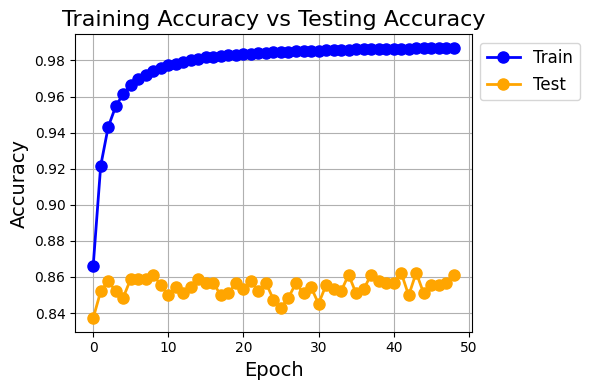

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(train_acc_, marker='o', linestyle='-', color='blue', label='Train', linewidth=2, markersize=8)
plt.plot(test_acc_, marker='o', linestyle='-', color='orange', label='Test', linewidth=2, markersize=8)
plt.title('Training Accuracy vs Testing Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()

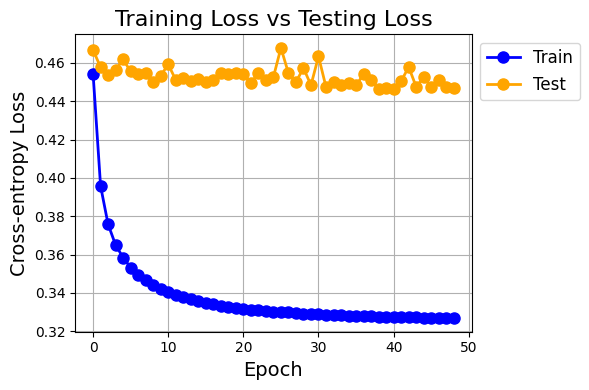

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_, marker='o', linestyle='-', color='blue', label='Train', linewidth=2, markersize=8)
plt.plot(test_loss_, marker='o', linestyle='-', color='orange', label='Test', linewidth=2, markersize=8)
plt.title('Training Loss vs Testing Loss', fontsize=16)
plt.ylabel('Cross-entropy Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()